In [16]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def plot_df(df):
    plt.figure()
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    df.plot(kind="line", x="step")

In [18]:
def drop_invariant(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    return df

In [19]:
def merge_dfs(df1, df2, only_shared=True):
    # Create a new DataFrame to store the merged columns
    merged_df = pd.DataFrame()

    if only_shared:
        df1_cols = set(df1.columns)
        df2_cols = set(df2.columns)

        shared_cols = df1_cols.intersection(df2_cols)
        
        for col in shared_cols:
            for i, df in enumerate([df1, df2]):
                merged_df[f'{col}_df{i + 1}'] = df[col]
        return merged_df, shared_cols
    
    # Merge columns from both DataFrames
    for col in df1.columns:
        merged_df[f'{col}_df1'] = df1[col]
        if col in df2.columns:
            merged_df[f'{col}_df2'] = df2[col]

    for col in df2.columns:
        if col not in df1.columns:
            merged_df[f'{col}_df2'] = df2[col]
    return merged_df

In [20]:
def common_columns(dfs, split=None):
    if split is None:
        return common_columns(dfs, "train"), common_columns(dfs, "val")
    col_sets = []
    for _, splits in dfs.items():
        col_sets.append(set(splits[split].columns))
    return set.intersection(*col_sets)

In [21]:
def add_median(dfs, metrics=["AR", "AP"], split="val"):
    for name, splits in dfs.items():
        for metric in metrics:
            filtered_cols = [col for col in splits[split].columns if col.startswith(metric)]
            dfs[name][split][f"m{metric}"] = splits[split][filtered_cols].mean(axis=1)
    return dfs

In [22]:
INPUT_DIR = "../processing/leaf_segmentation/metrics"
dfs = {}

for dir in os.listdir(INPUT_DIR):
    dir_path = os.path.join(INPUT_DIR, dir)
    if os.path.isfile(dir_path):
        continue
    files = os.listdir(dir_path)
    trains = [file for file in files if "train" in file]
    vals = [file for file in files if "val" in file]
    if len(trains) == 0 or len(vals) == 0:
        continue
    trains.sort()
    vals.sort()
    last_train = os.path.join(dir_path, trains[-1])
    last_val = os.path.join(dir_path, vals[-1])
    dfs[dir] = {
        "train": drop_invariant(pd.read_csv(last_train)),
        "val": drop_invariant(pd.read_csv(last_val))
    }
dfs = add_median(dfs)
COLS_TRAIN, COLS_VAL = common_columns(dfs)

In [23]:
print(COLS_TRAIN)
print(COLS_VAL)

{'training', 'model', 'step', 'total'}
{'AP75', 'mAP', 'AP', 'AP50', 'mAR', 'ARmax10', 'ARmax100', 'APs', 'ARs', 'steps_per_second', 'step', 'ARmax1'}


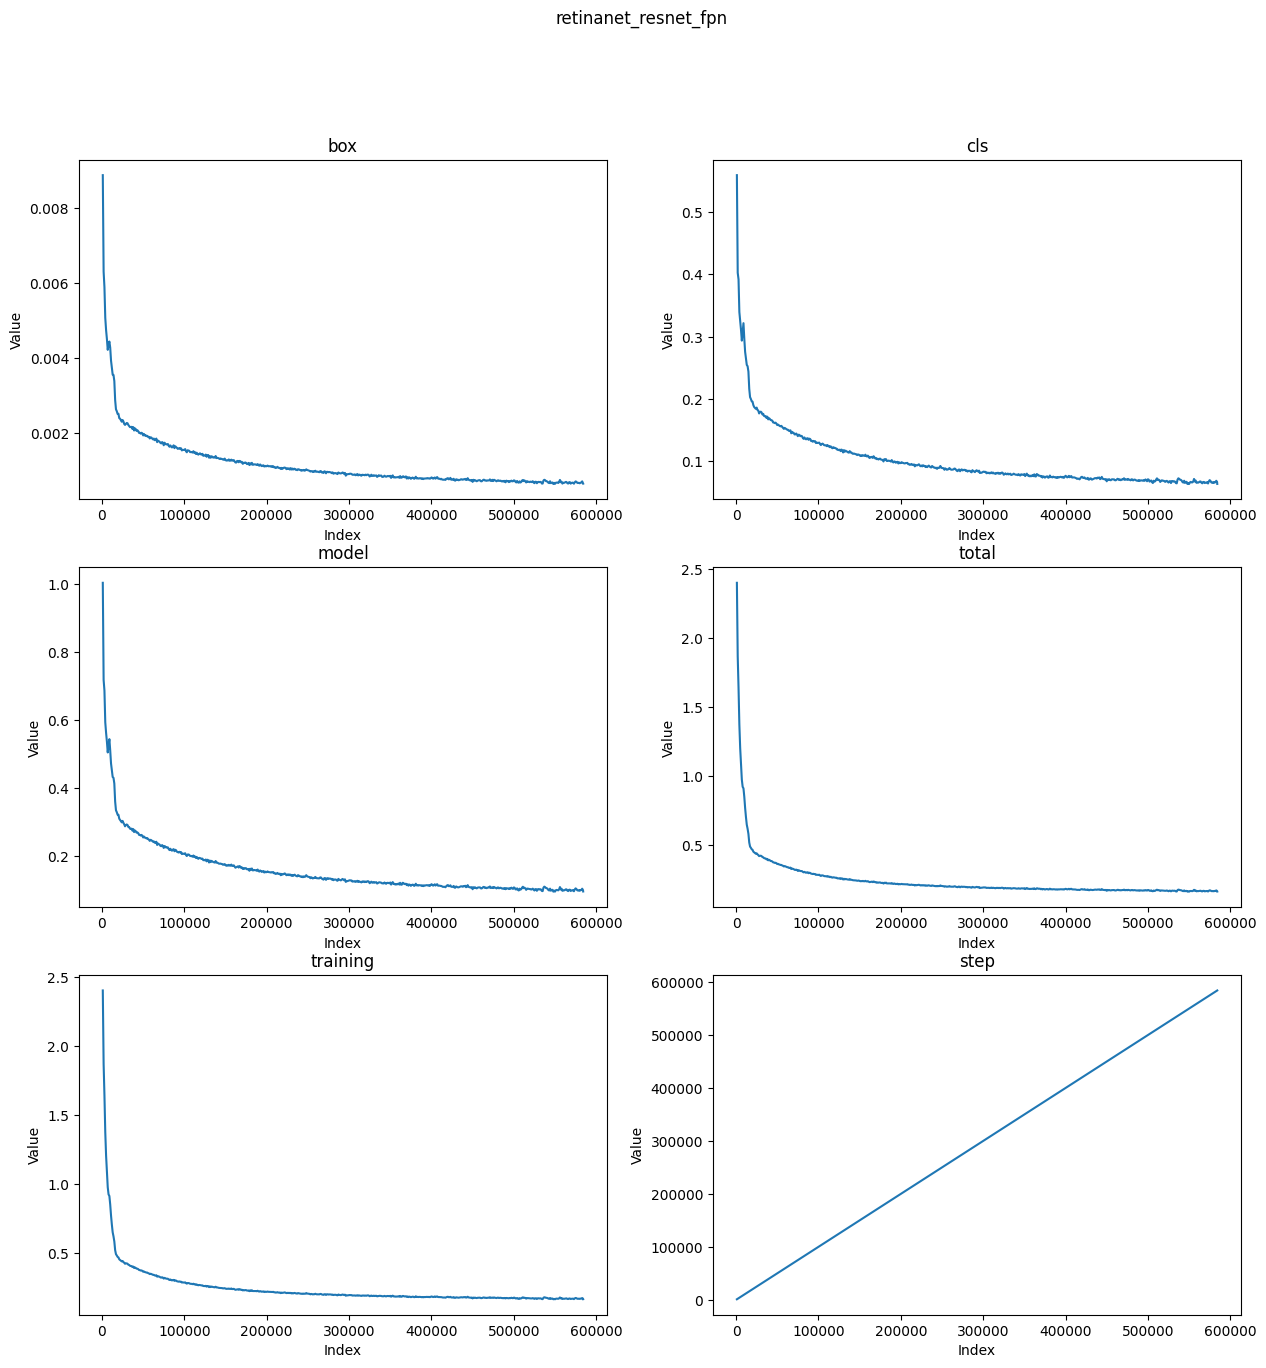

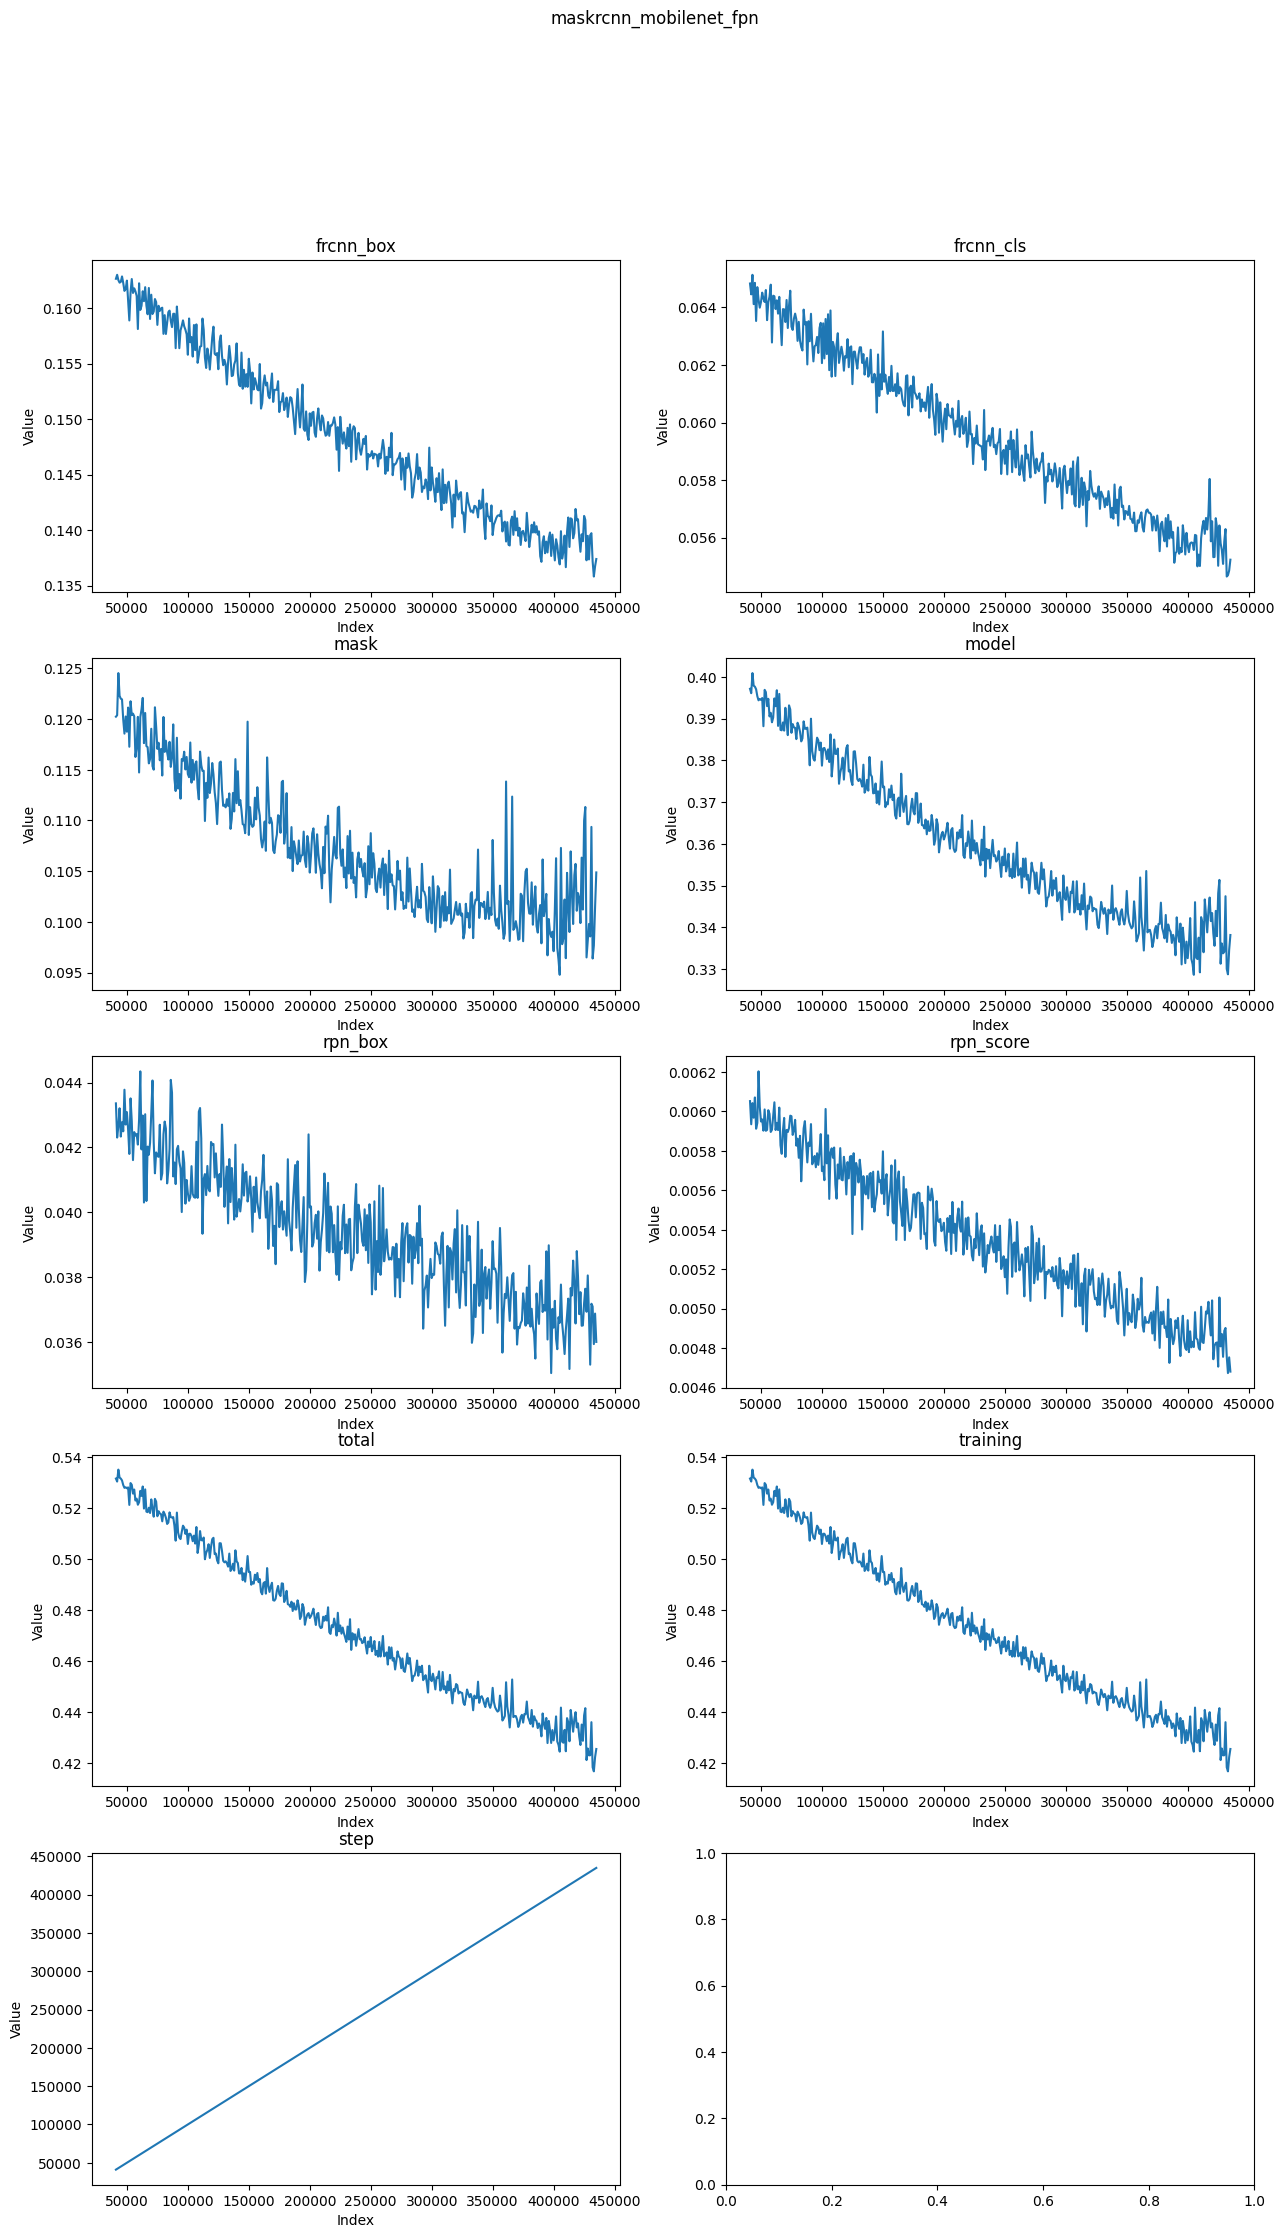

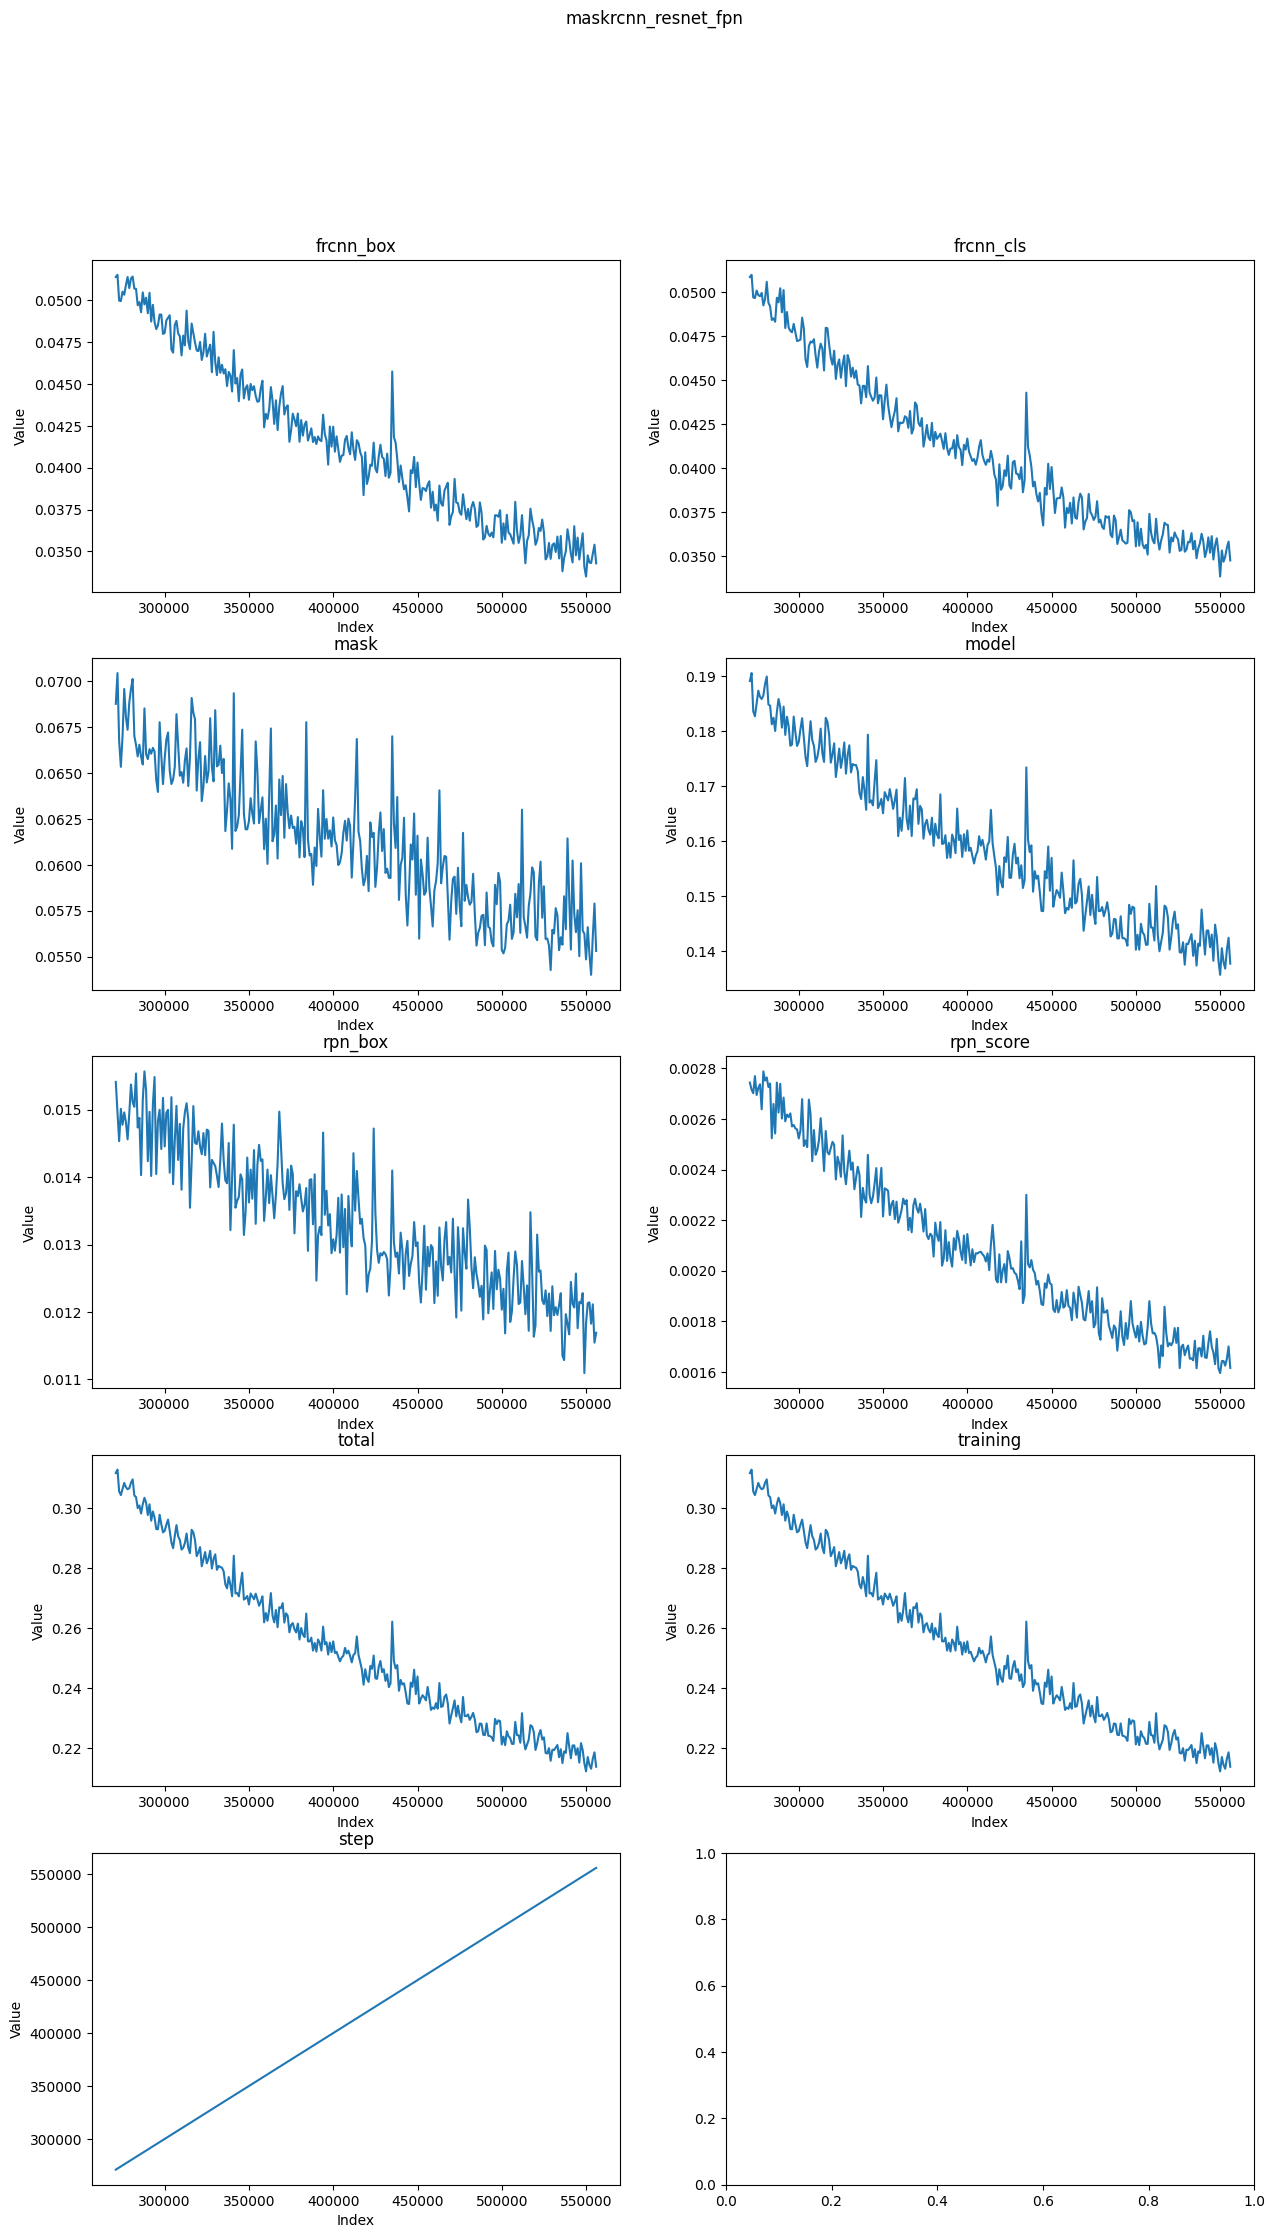

In [24]:
for name, splits in dfs.items():
    n_cols = len(splits["train"].columns)
    n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

    # Create subplots
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
    fig.suptitle(name)
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot each column
    for i, col in enumerate(splits["train"].columns):
        axes[i].plot(splits["train"]["step"], splits["train"][col])
        axes[i].set_title(col)
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Value')

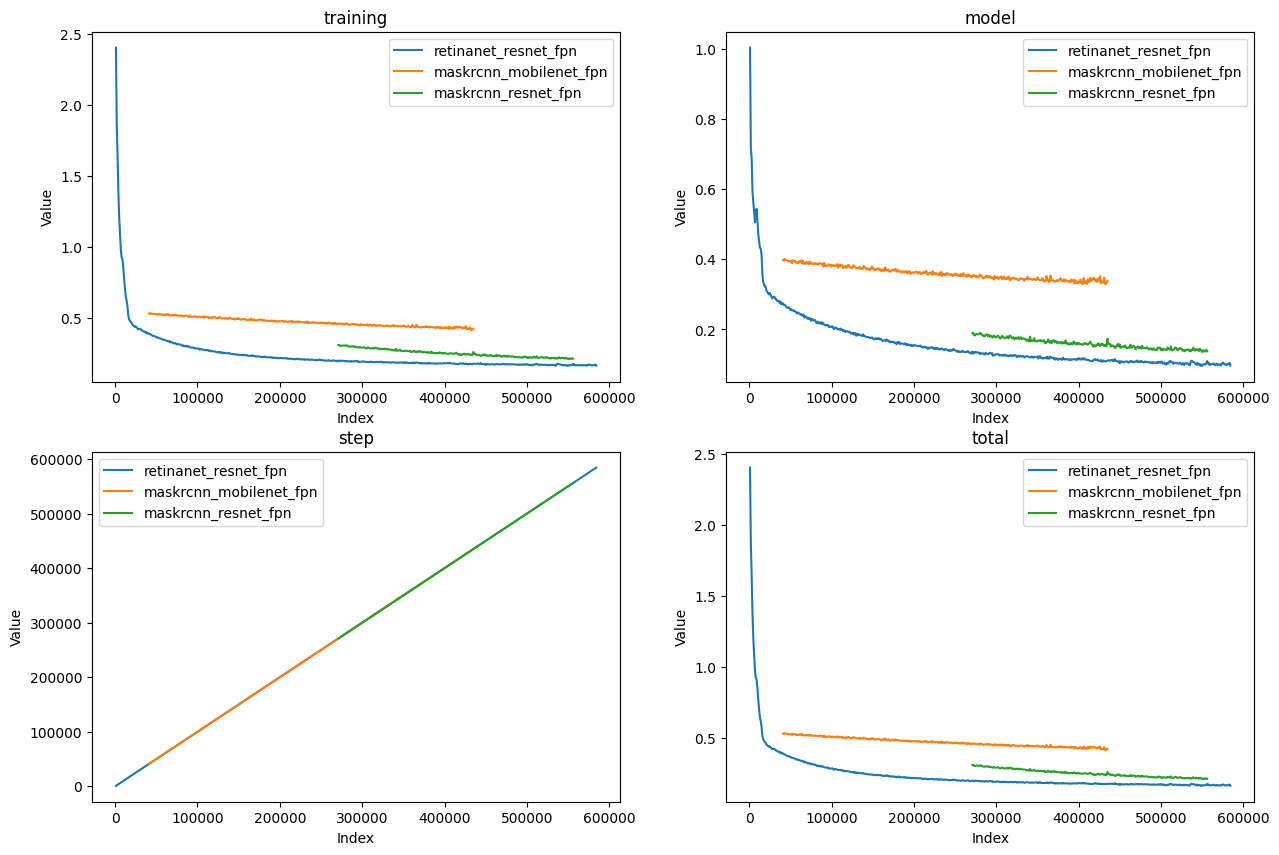

In [25]:
n_cols = len(COLS_TRAIN)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(COLS_TRAIN):
    for name, splits in dfs.items():
        axes[i].plot(splits["train"]["step"], splits["train"][col], label=name)
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

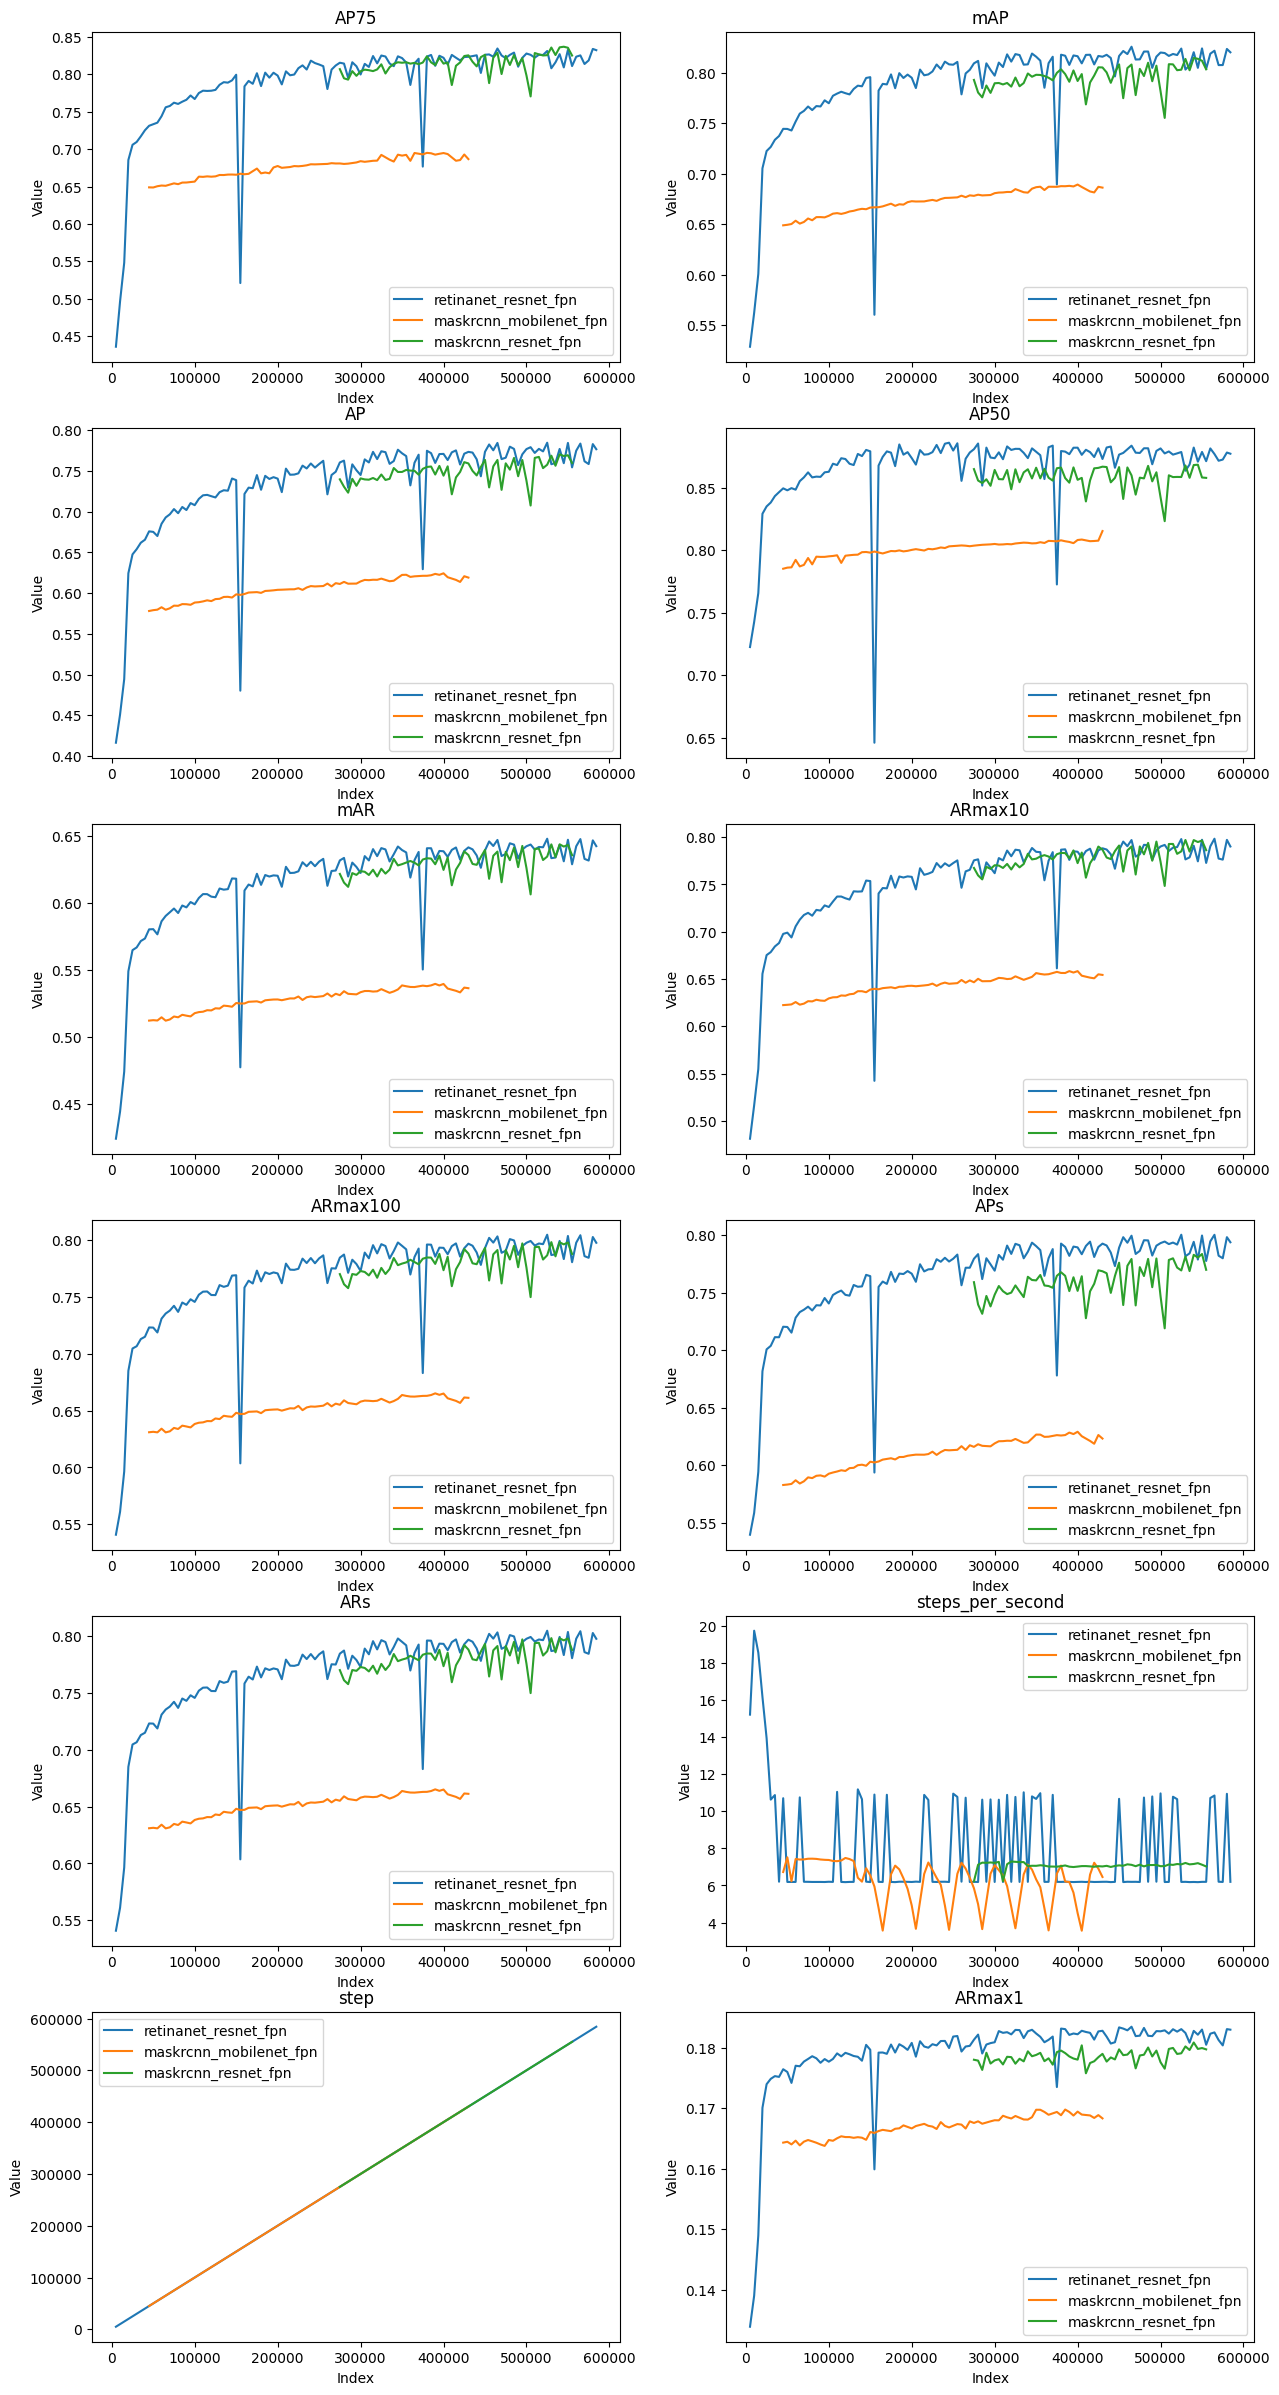

In [26]:
n_cols = len(COLS_VAL)
n_rows = (n_cols + 1) // 2  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each column
for i, col in enumerate(COLS_VAL):
    for name, splits in dfs.items():
        axes[i].plot(splits["val"]["step"], splits["val"][col], label=name)
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].legend()

In [27]:
extreme_values_train = pd.DataFrame()
extreme_values_val = pd.DataFrame()
for name, splits in dfs.items():
    min = splits["train"][list(COLS_TRAIN)].min(axis='rows')
    max = splits["train"][list(COLS_TRAIN)].max(axis='rows')
    extreme_values_train = pd.concat([extreme_values_train, pd.DataFrame({'min': min, 'max': max, 'name': name})])
    
    min = splits["val"][list(COLS_VAL)].min(axis='rows')
    max = splits["val"][list(COLS_VAL)].max(axis='rows')
    extreme_values_val = pd.concat([extreme_values_val, pd.DataFrame({'min': min, 'max': max, 'name': name})])

In [28]:
extreme_values_train

,min,max,name
training,0.164862,2.402513,retinanet_resnet_fpn
model,0.096219,1.003126,retinanet_resnet_fpn
step,1000.000000,584200.000000,retinanet_resnet_fpn
total,0.164862,2.402513,retinanet_resnet_fpn
training,0.416739,0.535220,maskrcnn_mobilenet_fpn
model,0.328651,0.400872,maskrcnn_mobilenet_fpn
step,41000.000000,435000.000000,maskrcnn_mobilenet_fpn
total,0.416739,0.535220,maskrcnn_mobilenet_fpn
training,0.212169,0.312746,maskrcnn_resnet_fpn
model,0.135611,0.190594,maskrcnn_resnet_fpn


In [29]:
extreme_values_val

,min,max,name
AP75,0.435825,0.834514,retinanet_resnet_fpn
mAP,0.528508,0.825530,retinanet_resnet_fpn
AP,0.416279,0.784669,retinanet_resnet_fpn
AP50,0.645934,0.886042,retinanet_resnet_fpn
mAR,0.424151,0.647724,retinanet_resnet_fpn
ARmax10,0.481271,0.798338,retinanet_resnet_fpn
ARmax100,0.540726,0.804930,retinanet_resnet_fpn
APs,0.539409,0.800358,retinanet_resnet_fpn
ARs,0.540726,0.804930,retinanet_resnet_fpn
steps_per_second,6.180171,19.739525,retinanet_resnet_fpn
